In [1]:
import numpy as np
import igraph
import scipy
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import networkx as nx
import anndata as ad
import phate

In [2]:
counts_sanger_Pf = pd.read_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/data/pf10xIDC_github/pf10xIDC_counts.csv')
PC_file_Pf = pd.read_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/data/pf10xIDC_github/pf10xIDC_pheno.csv')

In [3]:
# transpose matrix
counts_sanger_Pf = counts_sanger_Pf.transpose()

In [4]:
# set the first row to a column
counts_sanger_Pf.columns = counts_sanger_Pf.iloc[0]

In [5]:
# drop that row
counts_sanger_Pf = counts_sanger_Pf.drop(counts_sanger_Pf.index[0])

In [6]:
# create row names (index) and column names (gene) names
counts_sanger_Pf.index.names = ['Cells']
counts_sanger_Pf.columns.names = ['Genes']

In [7]:
# initalize dictionary
gff_dict_Pf = {new_list: [] for new_list in counts_sanger_Pf.columns}

In [8]:
with open('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/metadata/Pf_genome/PlasmoDB-62_Pfalciparum3D7.gff') as annotation_f:
    for gff_line in annotation_f:
        clean_gff_line = gff_line.strip()
        # don't forget about header (##)
        if '##' not in clean_gff_line and 'RNA' in clean_gff_line:
            clean_gff_list = clean_gff_line.split('\t')
            # Store the gene ID in the Parent entry in each accession
            ID = clean_gff_list[8].split(';')[1][7:]
            #print(ID)
            # only store genes in the file and with an empty list
            if ID in gff_dict_Pf.keys() and gff_dict_Pf[ID] == []:
                # Find the index that begins the gene name
                start_of_name = gff_line.find('description') + 12
                #Store the gene name in the variable description
                description = gff_line[start_of_name:].split(';')[0]
                # If there is a space, replace it with an underscore
                if ' ' in description:
                    # Replace the space with an underscore
                    name_nowt = description.replace(' ', '_')
                    # Replace the ACII code for a comma with a blank string and replace - with an underscore
                    if '%2C' in description or '-' in description or '/' in description or '(' in description or ')' in description or '[' in description or ']' in description or "'" in description or "+" in description:
                        name_nocomma = name_nowt.replace('%2C', '')
                        name_nounder = name_nocomma.replace('-', '_')
                        name_nopara = name_nounder.replace('(', '_')
                        name_nopara2 = name_nopara.replace(')', '_')
                        name_nobracket = name_nopara2.replace('[', '_')
                        name_nobracket2 = name_nobracket.replace(']', '_')
                        name_noapo = name_nobracket2.replace("'", '_')
                        name_noplus = name_noapo.replace("+", "plus")
                        name = name_noplus.replace('/', '_')
                    # If the name does not have those characters, then store name
                    else:
                        name = name_nowt
                gff_dict_Pf[ID].append(name)

In [9]:
gene_IDs = []
for a in counts_sanger_Pf.columns:
     gene_IDs.append(
        {
            'PK_ID': a,
            'Gene': ''.join(gff_dict_Pf[a])
        }
    )
gene_IDs = pd.DataFrame(gene_IDs)

In [10]:
# load the cell by gene matrix
adata_Pf = sc.AnnData(counts_sanger_Pf,
    counts_sanger_Pf.index.to_frame(),
    counts_sanger_Pf.columns.to_frame())

/var/folders/b3/_d0b62ts645bnlhb2xdb86xm0000gn/T/ipykernel_89580/1694481457.py:2: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_Pf = sc.AnnData(counts_sanger_Pf,


In [11]:
# add
adata_Pf.var['gene_symbols'] = gene_IDs['Gene'].tolist()

In [12]:
adata_Pf.var_names = adata_Pf.var['gene_symbols']

In [13]:
# make names unique
adata_Pf.var_names_make_unique(join='')
adata_Pf.var_names
adata_Pf.obs["cell_type"] = pd.Categorical(PC_file_Pf.bulk.values)

In [14]:
# log normalize
sc.pp.log1p(adata_Pf)
sc.tl.pca(adata_Pf, svd_solver='arpack')

/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


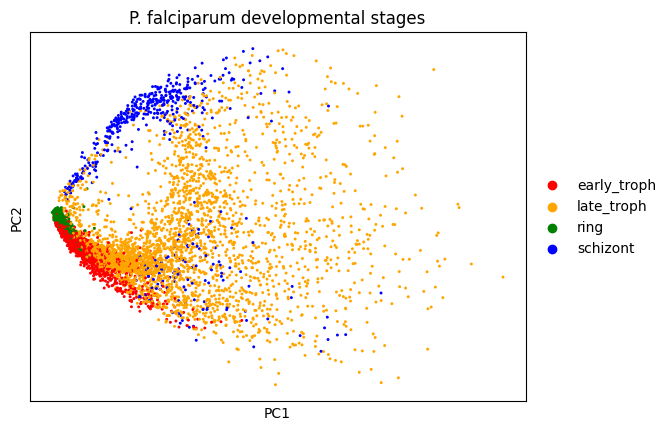

In [32]:
sc.pl.pca(adata_Pf,
          color="cell_type",
          save='_Pf.png',
          title = "P. falciparum developmental stages",
          palette={
              "ring": "green",
              "early_troph": "red",
              "late_troph": "orange",
              "schizont": "blue",
    })

2023-04-29 23:19:44.690257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


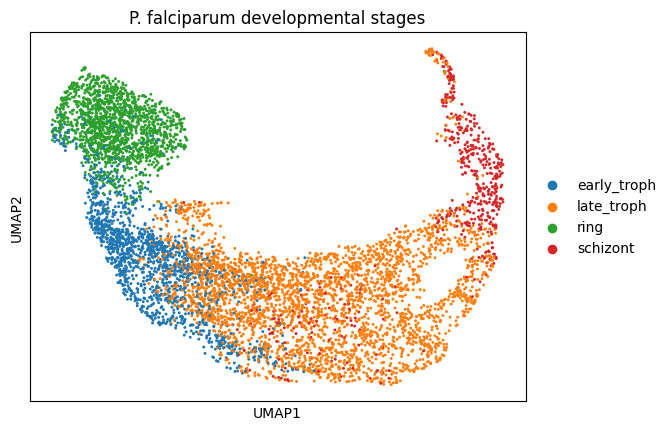

In [16]:
sc.pp.neighbors(adata_Pf, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_Pf)
sc.pl.umap(adata_Pf,color="cell_type",save='_Pf.png',title = 'P. falciparum developmental stages')

In [17]:
# dense node features matrix
# edit to just use the PCs
#log_trans_node_feat = np.array(adata_Pf.X)
log_trans_node_feat = np.array(adata_Pf.obsm['X_pca'])
# dense adjacency matrix
adj_COO = adata_Pf.obsp['connectivities']
# labels
labels = np.asarray(PC_file_Pf.bulk.values)

In [26]:
log_trans_node_feat.shape

(6737, 50)

In [18]:
import torch
import networkx as nx
import spektral
from spektral.data import Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.layers import GCNConv

class MyDataset(Dataset):
    """
    A dataset of one Pf graph from the MCA.
    """
    def __init__(self, nodes, feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
    def read(self):
        output = []
        A = adj_COO
        Y = PC_file_Pf.bulk.values
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            spektral.data.Graph(x=self.feats.astype("float32"),
                                a=A.astype("float32"),
                                y=YY.astype("float32").todense()))
        return output

n_nodes = labels.shape[0]
dataset = MyDataset(nodes = np.array(list(range(0,n_nodes))),
                    feats = log_trans_node_feat,
                    transforms=[LayerPreprocess(GCNConv)])

In [19]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7
test_ratio = 0.30
# calculate the number of nodes
n_nodes = labels.shape[0]
# create a np array of every node from 1 to max number of nodes
nodes = np.array(list(range(0,n_nodes)))
# split data into test first
X_train, X_test, y_train, y_test = train_test_split(pd.Series(nodes),
                                                    pd.Series(labels),
                                                    test_size=test_ratio,
                                                    random_state=42)
train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess

learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10

# We convert the binary masks to sample weights so that we can compute the
# average loss over the nodes (following original implementation by
# Kipf & Welling)
def mask_to_weights(mask):
    return mask.type(torch.float32) / np.count_nonzero(mask)

weights_tr, weights_te = (mask_to_weights(mask) for mask in (train_mask, test_mask))

# instantiate the model
model = GCN(n_labels=dataset.n_labels)

model.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

2023-04-29 23:20:03.086530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
from spektral.data.loaders import SingleLoader

# Train model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr.numpy())

model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

# Evaluate model
loader_te = SingleLoader(dataset, sample_weights=weights_te.numpy())

train_results = model.evaluate(loader_tr.load(), steps=loader_tr.steps_per_epoch)
test_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print('#' * 50)
print('Train Accuracy: %s' %train_results[1] )
print('Test Accuracy: %s' % test_results[1])
print('#' * 50)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.3299 - acc: 0.1775
Epoch 2/200
1/1 [==============================] - 0s 17ms/step - loss: 2.0482 - acc: 0.2189
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 1.8218 - acc: 0.2662
Epoch 4/200
1/1 [==============================] - 0s 16ms/step - loss: 1.5657 - acc: 0.2914
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 1.3581 - acc: 0.3379
Epoch 6/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2069 - acc: 0.3934
Epoch 7/200
1/1 [==============================] - 0s 16ms/step - loss: 1.0940 - acc: 0.4677
Epoch 8/200
1/1 [==============================] - 0s 16ms/step - loss: 0.9769 - acc: 0.5466
Epoch 9/200
1/1 [==============================] - 0s 16ms/step - loss: 0.8765 - acc: 0.6165
Epoch 10/200
1/1 [==============================] - 0s 16ms/step - loss: 0.8057 - acc: 0.6867
Epoch 11/200
1/1 [==============================] - 0s 16ms/step - loss

In [34]:
# get the indices of the test
#samps_to_predict = labels[X_test.index]
#samps_to_predict = np.array(X_test.index.tolist())

# use this to access the rows of the dataframe

test_train = []
# create a label with a for loop to create a series, which is cells in one column and in test in another column (T/F)
for x, y in enumerate(counts_sanger_Pf.index.tolist()):
    if x in X_test.index.tolist():
        test_train.append([y,'Test'])
    else:
        test_train.append([y,'Train'])
test_train = pd.DataFrame(test_train)
test_train.columns = ['Cells','test_train']
cells_in_test = test_train.loc[test_train['test_train'] == 'Test']

# add to adata object
adata_Pf.obs['test_train'] = "Train"
adata_Pf.obs.loc[cells_in_test['Cells'],'test_train'] = 'Test'

# subset the adata object by that
# adata = adata[adata.obs["sample"] == "ctrl_13",:]
#

# plot and color by whether in test or not
#sc.pl.pca(adata_Pf, color="test_train",save='_Pf_test_train.png')

# get samples to predict
#adata_sub = adata_Pf[adata_Pf.obs["test_train"] == "Test",:]

# use model.predict here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md
predictions = model.predict(loader_te.load(),steps=loader_te.steps_per_epoch)

# get the highest probability for each class
classes = np.argmax(predictions, axis = 1)
labels = {0: 'early_troph', 1: 'late_troph', 2:'ring',3:'schizont'}
str_class = []
for i in classes:
    str_class.append(labels[i])

# get the original classes
#original_class = pd.factorize(PC_file_Pf.bulk.values.tolist(),sort=True)
original_class = np.array(PC_file_Pf.bulk.values.tolist())
#print(original_class)

1/1 [==============================] - 0s 261ms/step


In [35]:
str_class = np.array(str_class)
# subset based on test indices
predictions_test = str_class[X_test.index.tolist()]
original_class_test = original_class[X_test.index.tolist()]

              precision    recall  f1-score   support

 early_troph       0.91      0.80      0.85       468
  late_troph       0.88      0.96      0.92       925
        ring       0.96      0.97      0.97       468
    schizont       0.92      0.75      0.83       161

    accuracy                           0.91      2022
   macro avg       0.92      0.87      0.89      2022
weighted avg       0.91      0.91      0.91      2022



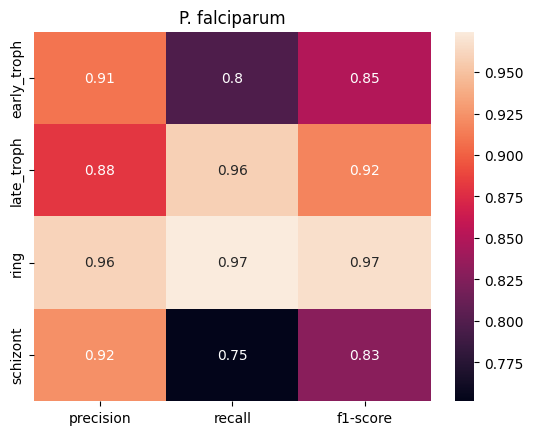

In [53]:
# calculate F1 score: https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(original_class_test, predictions_test,zero_division=0))

report = classification_report(original_class_test, predictions_test,zero_division=0,output_dict=True)
report_df = pd.DataFrame.from_dict(report)
report_df.to_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/scripts/analysis_script/figures/Pf_report.csv')
report_heat = sns.heatmap(report_df.iloc[:-1, :-3].T,
            annot=True)
report_heat.set_title('P. falciparum')
report_heat_fig = report_heat.get_figure()
report_heat_fig.savefig("figures/Pf_prediction_table.png", dpi=400, bbox_inches = "tight")
#print(PC_file_Pf.bulk.values.tolist())

#type(classes)
#print(adata_Pf.obs['test_train'][2475])
#print(samps_to_predict.shape)
#print(adata_Pf.obs['test_train'])

In [37]:
a]data_test = adata_Pf[adata_Pf.obs["test_train"] == "Test",:]

# # compare prediction vs. original
def compareList(l1, l2):
    return ["Correct" if i==j else "Incorrect" for i, j in zip(l1, l2)]
prediction_label = compareList(predictions_test,original_class_test)

In [38]:
adata_test.obs['prediction'] = prediction_label

/var/folders/b3/_d0b62ts645bnlhb2xdb86xm0000gn/T/ipykernel_89580/3242742153.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['prediction'] = prediction_label


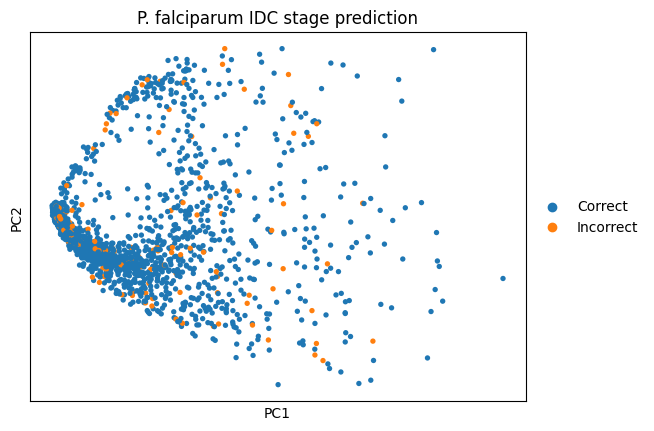

In [40]:
sc.pl.pca(adata_test,
          color="prediction",
          save='_Pf_prediction.png',
          title = 'P. falciparum IDC stage prediction')